<a href="https://colab.research.google.com/github/nicoleweimar/LunarLandingRL/blob/main/LunarLandingRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!apt-get update
!apt-get install -y swig
!pip install box2d-py

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:5 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:8 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Fetched 384 kB in 2s (193 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading pac

In [19]:
'''
Gym --> This is the library interface for the environment. This is how you interact, change and receive rewards from your
enviroment.
The rest of the libraries are known from previous workshops.
'''

import gym #environment for model RL needs environment
from gym.wrappers import RecordVideo
import os
import numpy as np
# Patch for deprecated np.bool8
if not hasattr(np, "bool8"):
    np.bool8 = np.bool_
import torch
import torch.nn as nn
import torch.optim as optim #gives adam..
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
from collections import deque

We will use the lunar landing environment from OpanAI's Gym library.
You can see the environemnt below!


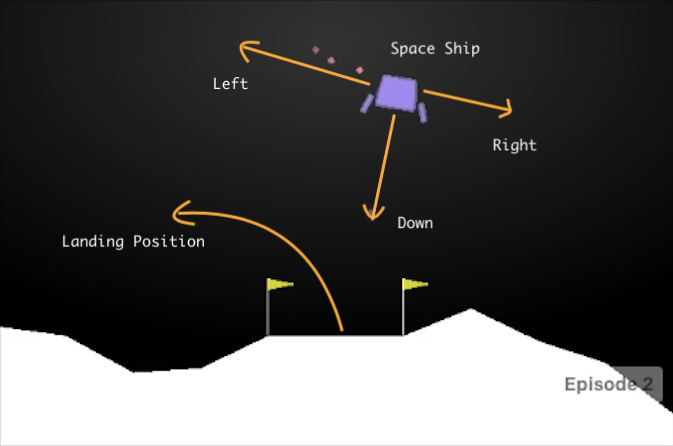

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make(
    "LunarLander-v2", new_step_api=True)

observation_space = env.observation_space.shape[0]
action_space = env.action_space.n
print("Observation space:", observation_space) #observation space is like state space
print("Action space:", action_space) #action space, all possible observations you can make

Observation space: 8
Action space: 4


In [21]:
env.reset()
val = env.step(0) #takes an action then changes the state
print(val)
env.close()

(array([-1.3255120e-03,  1.4328885e+00, -6.7044958e-02,  4.7532767e-01,
        1.5262393e-03,  1.5033878e-02,  0.0000000e+00,  0.0000000e+00],
      dtype=float32), np.float64(1.404589568627273), False, False, {})


In [22]:
# Define the QNetwork class
class QNetwork(nn.Module):
    def __init__(self):
        # Initialize the parent class (nn.Module)
        super(QNetwork, self).__init__()

        self.fc1 = nn.Linear(8,64)
        self.fc2 = nn.Linear(64,64)
        self.fc3 = nn.Linear(64,4)

        self.relu = nn.ReLU()
        # Define layers here
        #nueral network takes in an 8 dimensional networks and spits out a 6 dimentional one

    # Define the forward pass (how the data moves through the network)
    def forward(self, x, mode=False):
        # If mode is True, prevent gradient calculations (for evaluation)
        if mode == True:
          with torch.no_grad():
            x = self.fc1(x)
            x = self.relu(x)  #this is our activation function
            x = self.fc2(x)
            x = self.relu(x)
            x = self.fc3(x)

        else:
          x = self.fc1(x)
          x = self.relu(x)  #this is our activation function
          x = self.fc2(x)
          x = self.relu(x)
          x = self.fc3(x)

        return x  #output result

In [23]:
input = torch.randn(1, 8) #generate a random tensor of size 1x8 to input into our model -> should get an output of dem 1x4
model = QNetwork()
output = model(input)

print(output.shape == torch.Size([1, 4]))

True


In [24]:
# Create main Q Network and target Q Network
main_net = QNetwork()
target_net = QNetwork()

# Initialize the network to a device here to use
main_net = main_net.to(device)
target_net = target_net.to(device)

optimizer = optim.Adam(main_net.parameters(), lr = 0.001)
criterion = nn.MSELoss()

# Initialize optimizer and loss, what loss do you think we use here



In [25]:
#This function here is our update function for our main and target networks

def soft_update(target_net, main_net, tau=0.005):
    for target_param, main_param in zip(target_net.parameters(), main_net.parameters()):
        target_param.data.copy_(
            tau * main_param.data + (1 - tau) * target_param.data
        ) #lagged version versus current, updating

In [26]:
# Replay buffer skeleton
class ReplayBuffer:
    def __init__(self, capacity):
        # Initialize buffer with a fixed capacity
        self.buffer = deque(maxlen = capacity)

    def push(self, state, action, reward, next_state):
        # Add a new (state, action, reward, next_state) tuple to the buffer
        self.buffer.append((state, action, reward, next_state))
        pass

    def sample(self, batch_size):
        # Randomly sample a batch of (state, action, reward, next_state) tuples from the buffer
        # Use zip(*batch) to separate states, actions, rewards, and next_states
        batch = random.sample(self.buffer, batch_size)
        # batch is a list of tuples where each tuple has your state action reward and next state
        states = []
        actions = []
        rewards = []
        next_states = []
        for state, action, reward, next_state in batch:
          states.append(state)
          actions.append(action)
          rewards.append(reward)
          next_states.append(next_state)

        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states)
        pass

    def __len__(self):
        # Return the current size of the buffer
        return len(self.buffer)


In [27]:
# Example buffer
buffer = ReplayBuffer(capacity=1000)
for i in range(10):
    buffer.push(np.random.rand(8), np.random.randint(0, 4), np.random.rand(), np.random.rand(8))
#observation, action, reward and next state that you enter
states, actions, rewards, next_states = buffer.sample(5)
print(states.shape, actions.shape, rewards.shape, next_states.shape)

(5, 8) (5,) (5,) (5, 8)


In [28]:
# Define a function to choose an action based on an epsilon value, exploration vs exploitation

def explore_or_exploit(state, main_net, epsilon):
    # Generate a random number and decide on action choice
    if random.random() < epsilon:  # Check if random value is less than epsilon
        return np.random.randint(0,4)  # Return a random action if exploring
    else:
        # Return the action with the highest Q-value if exploiting
        action = main_net(state.to(device))  # Compute Q-values and choose the highest one
        action = torch.argmax(action, dim =1).item()
        return action
#this emulates the epsilon greedy algorithm
    # Calculate action probabilities and select based on distribution
#    action = None  # Compute Q-values for the state
#    probability = None  # Convert Q-values to probabilities
#   action = None  # Sample from probabilities to pick an action
#   return action

print(explore_or_exploit(torch.randn(1, 8), main_net, 0.1))

2


In [29]:
# Define the update function for training the main_net based on the replay buffer 📊

def update(replay_buffer, main_net, target_net, optimizer, batch_size, discount_factor):
    # Check if the replay buffer has enough data to proceed
    if len(replay_buffer) >= batch_size:
        # Sample a batch of data from the replay buffer
        states, actions, rewards, next_states = replay_buffer.sample(batch_size)

        # Convert samples to tensors and send them to the device 💻
        states_tensor = torch.tensor(states, dtype = torch.float32).to(device)  # Convert states to tensor and move to device
        next_states_tensor = torch.tensor(next_states, dtype = torch.float32).to(device)  # Convert next_states to tensor and move to device
        action_tensor = torch.tensor(actions, dtype = torch.long).to(device)  # Convert actions to tensor and move to device
        reward_tensor = torch.tensor(rewards, dtype=torch.float32).to(device)  # Convert rewards to tensor and move to device

        # Get Q-values for the current states from the main network
        q_values = main_net(states_tensor)  # Compute Q-values for the current states
        row_indices = torch.arange(batch_size).to(device)  # Define row indices for gathering actions
        q_values = q_values[row_indices, action_tensor]  # Select Q-values corresponding to the actions taken

        # Calculate target Q-values using the target network 🔍
        with torch.no_grad():
            next_q_values = target_net(next_states_tensor).detach().clone()  # Compute Q-values for next states
            target_q = reward_tensor + discount_factor * torch.max(next_q_values, dim = 1)[0]  # Apply Bellman equation to get target Q-values

        # Calculate loss and update main_net
        loss = criterion(q_values, target_q)  # Compute the loss between q_values and target_q
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() #updates model with optimizer
        return loss.item()
    else:
        return None


In [30]:
# Define the train function to let the agent learn in the environment
#implementing exploitation, exporation, book keeping replay buffer, gradient descent
def train(env, episodes, batch_size=64):
    discount_factor = 0.9999
    epsilon_start = 1
    epsilon_end = 0.05
    epsilon_decay = 0.05
    epsilon = epsilon_start
    episode_rewards = []
    losses = []
    replay_buffer = ReplayBuffer(capacity=100000)

    for episode in range(episodes):
        state = env.reset()
        terminated = False
        truncated = False
        episode_reward = 0

        while not terminated and not truncated:
            input_state = torch.tensor(state, dtype= torch.float32).unsqueeze(0).to(device)
            action = explore_or_exploit(input_state, main_net, epsilon)  # Choose an action using exploration-exploitation strategy

            # Execute action and observe next state and reward
            next_state, reward, terminated, truncated, info = env.step(action)

            # Store experience in the replay buffer
            replay_buffer.push(state, action, reward, next_state)  # Fill in with state, action, reward, and next_state
            episode_reward += reward

            # Update the network based on replay buffer
            loss = update(replay_buffer, main_net, target_net, optimizer, batch_size, discount_factor) # Call the update function with appropriate arguments
            if loss is not None:
                losses.append(loss)

            # Check if the episode has ended and record stats
            if terminated or truncated:
                episode_rewards.append(episode_reward)
                avg_loss = np.mean(losses)  # Calculate the average loss for this episode
                losses = []
                print(f"Episode {episode}, Average Loss: {avg_loss}")
     #           print(f"Episode {episode}, Average Reward: {avg_reward}")
            state = next_state

        # Decay epsilon for less exploration over time
        epsilon = epsilon * epsilon_decay  # Adjust epsilon based on epsilon decay

        # Update the target network to track the main network
        # Call soft_update with appropriate arguments
        soft_update(target_net, main_net)

# Example call to train the agent
train(env, episodes=200)

Episode 0, Average Loss: 16.92604504312788
Episode 1, Average Loss: 85.26626032117814
Episode 2, Average Loss: 90.57922641692623
Episode 3, Average Loss: 88.48083300657676
Episode 4, Average Loss: 81.08487739525442
Episode 5, Average Loss: 70.09969668657007
Episode 6, Average Loss: 92.69299043814341
Episode 7, Average Loss: 81.19933628021403
Episode 8, Average Loss: 93.58293990527882
Episode 9, Average Loss: 79.06022118940587
Episode 10, Average Loss: 65.4831271940662
Episode 11, Average Loss: 42.95708908104896
Episode 12, Average Loss: 23.47981780362129
Episode 13, Average Loss: 16.545851857185365
Episode 14, Average Loss: 12.910575147271157
Episode 15, Average Loss: 9.489995178937912
Episode 16, Average Loss: 8.907932260155677
Episode 17, Average Loss: 7.986583628152546
Episode 18, Average Loss: 10.109045364379883
Episode 19, Average Loss: 8.522357868223354
Episode 20, Average Loss: 12.079069723142863
Episode 21, Average Loss: 10.070763026301568
Episode 22, Average Loss: 12.986219499

In [33]:
from gym.wrappers import RecordVideo
import os
os.environ['SDL_VIDEODRIVER']='dummy'
import pygame
pygame.display.set_mode((640,480))



'''
Ignore the internal dynamics of the test function
All that it does is save the output of the environment(the rdg array)
as a video, for later viewing.
'''

def test_agent(env, network, video_dir="./videos"):
    total_rewards = []

    # Set the network to evaluation mode
    network.eval()

    env = RecordVideo(env, video_dir)

    state = env.reset()
    terminated = False
    truncated = False
    episode_reward = 0

    while not terminated and not truncated:
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = network(state_tensor)
            action = torch.argmax(q_values, dim=1).item()

        next_state, reward, terminated, truncated = env.step(action)
        episode_reward += reward

        state = next_state

    total_rewards.append(episode_reward)
env = gym.make(
    "LunarLander-v2", render_mode = "rgb_array")
test_agent(env, main_net, video_dir="./videos")

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [34]:
from IPython.display import HTML
from base64 import b64encode

'''
Special thanks too korakot from Stack overflow for this
https://stackoverflow.com/questions/57377185/how-play-mp4-video-in-google-colab
'''
mp4 = open('./videos/rl-video-episode-0.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)